In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir

In [3]:
data_args = ml_collections.ConfigDict({
  'amp_norm_axis': -1,
  'amp_norm_type': 'std',
  'batch_size': 16,
  'component_order': 'ZNE',
  'demean_axis': -1,
  'dimension_order': 'NCW',
  'event_split_method': 'temporal',
  'num_workers': 8,
  'test_frac': 0.2,
  'train_frac': 0.7,
  'val_frac': 0.1,
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=9,
  **data_args
)


Seed set to 42
Seed set to 42


In [13]:

# model_relative_path = "/results/models/foreshock_aftershock_run/seisLM_base_shock_classifier_nc_9_frac_1.0_2024-09-10-14h-32m-11s/checkpoints/last.ckpt"
path_dict = {
  'SeisLM-base': "/results/models/foreshock_aftershock_run/seisLM_base_shock_classifier_nc_9_frac_1.0_2024-09-10-21h-54m-36s/checkpoints/last.ckpt",
  'SeisLM-large': "/results/models/foreshock_aftershock_run/seisLM_large_shock_classifier_nc_9_frac_1.0_2024-09-10-14h-34m-33s/checkpoints/last.ckpt"
}

def get_confusion_matrix(model_relative_path):
  model = Wav2vec2ShockClassifierLit.load_from_checkpoint(
    gitdir() + model_relative_path,
    load_pretrained=False
    )

  model = model.to(device)
  model = model.eval()

  all_gt_class = []
  all_pred_class = []
  all_losses = []

  model = model.to(device)
  model.eval()

  for X, y in loaders['test']:
    with torch.no_grad():
      logits = model(X.to(device)).cpu()
      pred_class = np.argmax(logits.numpy(), axis=1)
      loss = torch.nn.functional.cross_entropy(logits, y)
      all_losses.append(loss.item())

    all_gt_class.append(y)
    all_pred_class.append(pred_class)

  all_gt_class = np.concatenate(all_gt_class)
  all_pred_class = np.concatenate(all_pred_class)


  cm = confusion_matrix(all_gt_class, all_pred_class)
  cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  return np.rint(cm_percentage)

In [32]:
confusion_matrix_dict = {}
confusion_matrix_dict['ConvNet'] = np.array(
  [[84, 1, 0,  0, 0, 5, 0, 10, 1],
  [7, 68, 20, 3, 0, 0, 0,  0,  1],
  [4, 36, 43, 16, 1, 0, 0, 0, 1],
  [1, 2, 16, 58, 3, 0, 0,  5, 15],
  [0, 0, 0,  0, 99, 0, 0,  0, 0],
  [0, 0, 0, 0, 1, 80, 9,  10, 0],
  [0, 0, 0, 0, 0, 43, 1,  56, 0],
  [0, 0, 2, 0, 1, 1, 2,   30, 66],
  [1, 0, 0, 0, 0, 1,  0,   36, 62]]
).T


for key, val in path_dict.items():
  cm = get_confusion_matrix(val)
  confusion_matrix_dict[key] = cm




/tmp/ipykernel_26705/408011529.py:62: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use ax.tick_params and colorbar.set_label instead.
  grid.cbar_axes[0].toggle_label(True)  # Show colorbar labels


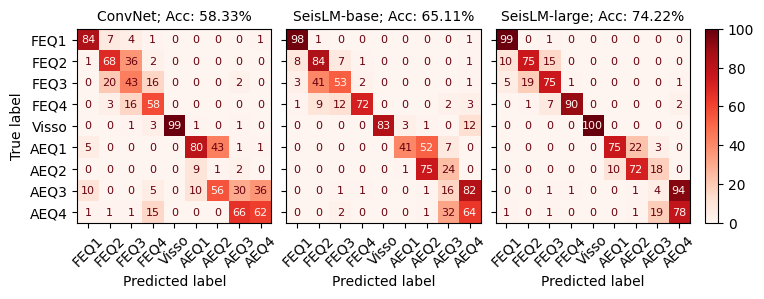

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.ticker import FormatStrFormatter
from seisLM.utils import project_path, plot_utils

# Assuming confusion_matrix_dict is already defined
A4_WIDTH = 8.27
FONT_SIZE = 10

# Create figure
fig = plt.figure(figsize=(A4_WIDTH, A4_WIDTH / 3))

# Set up ImageGrid
grid = ImageGrid(fig, 111,  # equivalent to plt.subplot(111)
                 nrows_ncols=(1, 3),  # 1 row, 3 columns
                 axes_pad=0.15,  # Padding between axes
                 share_all=True,  # Share axis labels
                 cbar_location="right",  # Place the colorbar on the right
                 cbar_mode="single",  # Only one colorbar for all plots
                 cbar_size="7%",  # Set colorbar size
                 cbar_pad=0.15)  # Padding between the colorbar and axes

# Update font size parameters for the plot
plt.rcParams.update({
    'font.size': FONT_SIZE,  # General font size
    'axes.titlesize': FONT_SIZE,  # Subplot titles
    'figure.titlesize': FONT_SIZE,  # Suptitle (main title)
    'legend.fontsize': FONT_SIZE,  # Legend font size
    'pdf.fonttype': 42,  # Embed fonts in PDF for better compatibility
})


# Function to format confusion matrix values as integers
def format_confusion_matrix_values(ax):
    # Loop over all text objects in the confusion matrix and format them
    for text in ax.texts:
        val = float(text.get_text())
        text.set_text(f'{int(val)}')  # Display as integer
        text.set_fontsize(8)

# Plot each confusion matrix in the grid
for i, (key, val) in enumerate(confusion_matrix_dict.items()):
    disp = ConfusionMatrixDisplay(
      confusion_matrix=val,
      display_labels=['FEQ1', 'FEQ2', 'FEQ3', 'FEQ4', 'Visso', 'AEQ1', 'AEQ2', 'AEQ3', 'AEQ4']
    )
    disp.plot(ax=grid[i], xticks_rotation=45, colorbar=False, cmap='Reds')  # No individual colorbars
    grid[i].set_title(key + "; Acc: {:.2f}%".format(val.diagonal().mean()))
    format_confusion_matrix_values(grid[i])

# Set the color range for all confusion matrices
vmin, vmax = 0, 100
for ax in grid:
    im = ax.get_images()[0]  # Get the image from the confusion matrix
    im.set_clim(vmin, vmax)  # Set the color limits


# Add a single colorbar for all plots
grid.cbar_axes[0].colorbar(im)  # Use the colorbar axis from ImageGrid
grid.cbar_axes[0].toggle_label(True)  # Show colorbar labels

# Display the figure
plt.show()
fig.savefig(
  project_path.FIGURE_DIR + f'/shock_confusion_matrix.pdf',
  bbox_inches='tight'
)